# Dynamic Frame Generation Using Machine Learning and Scene Data

This notebook holds my OpenCV code for preprocessing frameblocks. A frameblock is a section of an input image that I will use for later image processing and Machine Learning training. The correct calculation of frameblocks is important, since the machine learning algorithm may over-train or under-train if given poor training images.

In [1]:
import cv2 as cv2
import numpy as np
from matplotlib import pyplot as plt
img_str_1 = './images/samples/frame_1.jpg'
img_str_2 = './images/samples/frame_2.jpg'
img_str_3 = './images/samples/frame_3.jpg'
img_str_out = './images/output.jpg'
img_str_roi = './images/frameblock_roi.jpg'

## Frame Preprocessing

The process for generating frameblocks takes in an input of 2 images and outputs all frameblocks which meet our image processing requirements. Given these two image inputs, we must decide what portions of them are different enough to be used as frameblocks.

For this problem, we will need to process every frame with its neighbors. Luckily, the left neighbor will have already been calculated in the previous step. So we only need to compare each frame to its right neighbor for frameblock generation.

### Image processing initialization.

Now we must read the images (sample1.jpg and sample2.jpg). Boundaries are also chosen here, in case the images are different sizes. In theory for this application this wouldn't occur, however it doesn't take much time to check.

In [2]:
img_1 = cv2.cvtColor(cv2.imread(img_str_1), cv2.COLOR_BGR2RGB)
height_1, width_1 = img_1.shape[:2]
img_2 = cv2.cvtColor(cv2.imread(img_str_2), cv2.COLOR_BGR2RGB)
height_2, width_2 = img_2.shape[:2]

# Choose smallest boundaries
height = height_1
width = width_1
if height_1 > height_2:
    height = height_2
if width_1 > width_2:
    width = width_2

The images have been loaded and the variables height and width have been set. Below the two images are plotted side by side, as a reminder of how different they appear. In theory these images should be two consecutive frames, which usually means they will have very small differences.

(([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

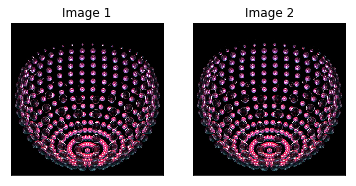

In [3]:
plt.subplot(121),plt.imshow(img_1),plt.title('Image 1')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img_2),plt.title('Image 2')
plt.xticks([]), plt.yticks([])

### XOR Image Creation

Here the pixels of each image are processed. A summation of pixel values is recorded while the loop is running; each pixel adds it's red, green, and blue (RGB) values together, caps the value at 255, and then adds this to the $pixel_sum$ variable.

My goal is to find pixel $P$, which represents the difference between the two input pixels. So for each pixel of the sample images (which I choose to denote as $p_i(x,y)$ for image i) I find the following value:

$$P = p_1(x,y) \oplus p_2(x,y)$$

and store this as the value for the output image.

In [4]:
img_out = np.ones((height, width, 3), np.uint8)
total_pixel_sum = 0

# Loop through each pixel.
for y in range(0, height):
    for x in range(0, width):
        #print(img_sample_1[y, x], img_sample_2[y, x])
        pixel_out = abs(img_1[y, x] ^ img_2[y, x])
        #print(pixel_out)
        pixel_sum = int(pixel_out[0]) + int(pixel_out[1]) + int(pixel_out[2])
        if pixel_sum > 255:
            bw_val = 255
        else:
            bw_val = np.uint8(pixel_sum)
        total_pixel_sum += bw_val
        bw_val = 255 - bw_val
        img_out[y, x] = bw_val
cv2.imwrite(img_str_out,img_out)

True

Below is the calculated output image. This image graphically shows the differences between frames, where white is no difference and black is maximal difference. We are able to use this later to calculate frameblocks.

(([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

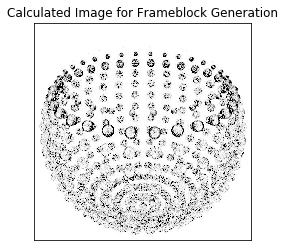

In [5]:
plt.subplot(111),plt.imshow(img_out),plt.title('Calculated Image for Frameblock Generation')
plt.xticks([]), plt.yticks([])

Now we need to find the percentage of black pixels to trigger frameblock. This is done by computing the total sum of pixel values in the calculated image and dividing it by how many black pixels are possible. Thus the value represents the probability of encountering a changed pixel in the image.

If the ratio calculated in this way is very low, that means there are very few black pixels so we need to lower our standard for selecting frameblocks. Similarly, if the ratio is close to 1, that means there are many more black pixels and we should raise the standard for selecting frameblocks. This value is directly tied to the input frames.

In [6]:
print("Total pixel sum: " + str(total_pixel_sum))
pixel_ratio = total_pixel_sum * 1.0 / (255 * width * height)
print("Pixel ratio: " + str(pixel_ratio))

Total pixel sum: 7386200
Pixel ratio: 0.11049457624846813


### Frameblock Selection

Now we select frameblocks using the above calculated image. Frameblocks are selected based on the percentage of black pixels (which in this case represents maximal difference). We need a sliding window to process frameblocks, since we want to skip as many pixels of the same image as possible. There is up to 50% overlap for each frameblock horizontally and vertically.

Each frameblock selected is saved to an image file. A red rectangle is also overlaid on top of the original calculated image to represent where each frameblock was selected from.

In [7]:
# Create a clone of input image and draw ROIs on top of it.
img_roi_all = cv2.imread(img_str_out)

# Create sliding window.
block_dim = 32
block_offset = 2
left = 0
right = block_dim
top = 0
bottom = block_dim
frame_index = 1
pixel_sum = 0
cap = np.power(block_dim, 2) * 255 * pixel_ratio
print("Cap found: " + str(cap))

# Find the Region Of Interest (ROI).
while bottom < height:
    found_y = False
    while right < width:
        found_x = False
        pixel_sum = 0
        # ROI pixel processing
        for y in range(top, bottom + 1):
            for x in range(left, right + 1):
                pixel_sum += 255 - img_out[y, x][0]
                if pixel_sum >= cap:
                    # Draw ROI on clone image.
                    cv2.rectangle(img_roi_all, (left, top), (right, bottom), (255, 0, 0), 1)
                    print("Sum: " + str(pixel_sum) + ", Frameblock: (" + str(left) + ", " + str(top) + "), (" + str(right) + ", " + str(bottom) + "))")
                    
                    # Store window contents as image.
                    img_roi_1 = img_1[top:bottom, left:right]
                    img_roi_2 = img_2[top:bottom, left:right]
                    
                    cv2.imwrite('./images/blocks/block' + str(frame_index) + '_1.jpg', img_roi_1)
                    cv2.imwrite('./images/blocks/block' + str(frame_index) + '_2.jpg', img_roi_2)
                    frame_index += 1
                    
                    # Exit both for loops.
                    found_x = True
                    break
            if found_x:
                break
        # Shift horizontally
        left += int(block_dim / block_offset)
        right += int(block_dim / block_offset)
    # Shift vertically
    top += int(block_dim / block_offset)
    bottom += int(block_dim / block_offset)
    left = 0
    right = block_dim

Cap found: 28852.34375
Sum: 28897, Frameblock: (176, 64), (208, 96))
Sum: 28994, Frameblock: (192, 64), (224, 96))
Sum: 28913, Frameblock: (208, 64), (240, 96))
Sum: 29073, Frameblock: (224, 64), (256, 96))
Sum: 28904, Frameblock: (240, 64), (272, 96))
Sum: 28880, Frameblock: (256, 64), (288, 96))
Sum: 28887, Frameblock: (272, 64), (304, 96))
Sum: 28887, Frameblock: (288, 64), (320, 96))
Sum: 28926, Frameblock: (304, 64), (336, 96))
Sum: 28888, Frameblock: (96, 80), (128, 112))
Sum: 29048, Frameblock: (112, 80), (144, 112))
Sum: 28988, Frameblock: (128, 80), (160, 112))
Sum: 28975, Frameblock: (144, 80), (176, 112))
Sum: 28949, Frameblock: (160, 80), (192, 112))
Sum: 28984, Frameblock: (176, 80), (208, 112))
Sum: 28893, Frameblock: (192, 80), (224, 112))
Sum: 28923, Frameblock: (208, 80), (240, 112))
Sum: 29088, Frameblock: (224, 80), (256, 112))
Sum: 28890, Frameblock: (240, 80), (272, 112))
Sum: 28900, Frameblock: (256, 80), (288, 112))
Sum: 28858, Frameblock: (272, 80), (304, 112))


Sum: 28970, Frameblock: (432, 208), (464, 240))
Sum: 28882, Frameblock: (448, 208), (480, 240))
Sum: 28912, Frameblock: (464, 208), (496, 240))
Sum: 28858, Frameblock: (16, 224), (48, 256))
Sum: 28869, Frameblock: (32, 224), (64, 256))
Sum: 28930, Frameblock: (48, 224), (80, 256))
Sum: 28972, Frameblock: (64, 224), (96, 256))
Sum: 28885, Frameblock: (80, 224), (112, 256))
Sum: 29070, Frameblock: (96, 224), (128, 256))
Sum: 28956, Frameblock: (112, 224), (144, 256))
Sum: 28960, Frameblock: (128, 224), (160, 256))
Sum: 29099, Frameblock: (144, 224), (176, 256))
Sum: 28991, Frameblock: (160, 224), (192, 256))
Sum: 28873, Frameblock: (176, 224), (208, 256))
Sum: 28910, Frameblock: (192, 224), (224, 256))
Sum: 29004, Frameblock: (208, 224), (240, 256))
Sum: 28870, Frameblock: (224, 224), (256, 256))
Sum: 28895, Frameblock: (256, 224), (288, 256))
Sum: 29035, Frameblock: (272, 224), (304, 256))
Sum: 28936, Frameblock: (288, 224), (320, 256))
Sum: 28999, Frameblock: (304, 224), (336, 256))
Su

Sum: 28975, Frameblock: (176, 320), (208, 352))
Sum: 28875, Frameblock: (192, 320), (224, 352))
Sum: 28861, Frameblock: (208, 320), (240, 352))
Sum: 28855, Frameblock: (224, 320), (256, 352))
Sum: 28861, Frameblock: (240, 320), (272, 352))
Sum: 29030, Frameblock: (256, 320), (288, 352))
Sum: 29097, Frameblock: (272, 320), (304, 352))
Sum: 28885, Frameblock: (288, 320), (320, 352))
Sum: 28866, Frameblock: (304, 320), (336, 352))
Sum: 28861, Frameblock: (320, 320), (352, 352))
Sum: 28877, Frameblock: (336, 320), (368, 352))
Sum: 28860, Frameblock: (352, 320), (384, 352))
Sum: 28861, Frameblock: (368, 320), (400, 352))
Sum: 28856, Frameblock: (384, 320), (416, 352))
Sum: 28924, Frameblock: (400, 320), (432, 352))
Sum: 28868, Frameblock: (416, 320), (448, 352))
Sum: 28903, Frameblock: (432, 320), (464, 352))
Sum: 28871, Frameblock: (448, 320), (480, 352))
Sum: 28858, Frameblock: (32, 336), (64, 368))
Sum: 29059, Frameblock: (48, 336), (80, 368))
Sum: 29006, Frameblock: (64, 336), (96, 368)

Sum: 28975, Frameblock: (128, 448), (160, 480))
Sum: 28871, Frameblock: (144, 448), (176, 480))
Sum: 28941, Frameblock: (160, 448), (192, 480))
Sum: 28944, Frameblock: (176, 448), (208, 480))
Sum: 28892, Frameblock: (192, 448), (224, 480))
Sum: 28857, Frameblock: (208, 448), (240, 480))
Sum: 28853, Frameblock: (224, 448), (256, 480))
Sum: 28950, Frameblock: (240, 448), (272, 480))
Sum: 28869, Frameblock: (256, 448), (288, 480))
Sum: 29016, Frameblock: (272, 448), (304, 480))
Sum: 28933, Frameblock: (288, 448), (320, 480))
Sum: 28861, Frameblock: (304, 448), (336, 480))
Sum: 28908, Frameblock: (320, 448), (352, 480))
Sum: 28886, Frameblock: (336, 448), (368, 480))
Sum: 28876, Frameblock: (352, 448), (384, 480))
Sum: 28915, Frameblock: (176, 464), (208, 496))
Sum: 29078, Frameblock: (192, 464), (224, 496))
Sum: 29093, Frameblock: (208, 464), (240, 496))
Sum: 28862, Frameblock: (224, 464), (256, 496))
Sum: 28865, Frameblock: (240, 464), (272, 496))
Sum: 28955, Frameblock: (256, 464), (288

The image with the overlaid frameblock areas is shown below.

(([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

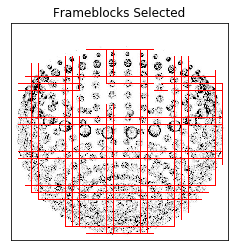

In [8]:
cv2.imwrite(img_str_roi, img_roi_all)
plt.subplot(111),plt.imshow(img_roi_all),plt.title('Frameblocks Selected')
plt.xticks([]), plt.yticks([])

Some of the generated frameblocks are shown below. Notice the visual differences between them; these frames were marked as different enough to be used as frameblocks for later training.

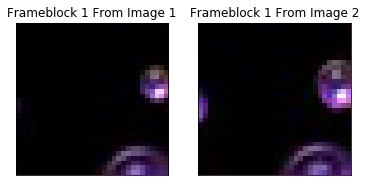

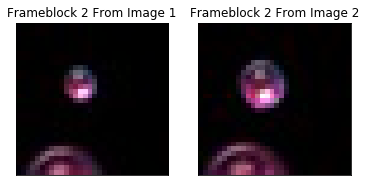

In [9]:
img_block_1 = cv2.cvtColor(cv2.imread('images/blocks/block1_1.jpg'), cv2.COLOR_BGR2RGB)
img_block_2 = cv2.cvtColor(cv2.imread('images/blocks/block1_2.jpg'), cv2.COLOR_BGR2RGB)
plt.subplot(121),plt.imshow(img_block_1),plt.title('Frameblock 1 From Image 1')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img_block_2),plt.title('Frameblock 1 From Image 2')
plt.xticks([]), plt.yticks([])
plt.show()
img_block_1 = cv2.imread('images/blocks/block2_1.jpg', cv2.COLOR_BGR2RGB)
img_block_2 = cv2.imread('images/blocks/block2_2.jpg', cv2.COLOR_BGR2RGB)
plt.subplot(121),plt.imshow(img_block_1),plt.title('Frameblock 2 From Image 1')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img_block_2),plt.title('Frameblock 2 From Image 2')
plt.xticks([]), plt.yticks([])
plt.show()

In [10]:
print("Done!")

Done!
